# Mixed logit with Toyota data

This demo uses the dataset that was made available by Kenneth Train at https://eml.berkeley.edu/~train/ec244ps.html

The data represent consumers' choices among vehicles in stated preference experiments. The data is from a study that Kenneth Train did for Toyota and GM to assist them in their analysis of the potential marketability of electric and hybrid vehicles, back before hybrids were introduced.

We begin by performing the necessary imports:

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
sys.path.insert(0, "/home/rodr/code/amortized-mxl-dev/release") 

import logging
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Fix random seed for reproducibility
np.random.seed(42)

## Load Toyota dataset

About the data:

In each choice experiment, the respondent was presented with three vehicles, with the price and other attributes of each vehicle described. The respondent was asked to state which of the three vehicles he/she would buy if the these vehicles were the only ones available in the market. There are 100 respondents in our dataset (which, to reduce estimation time, is a subset of the full dataset which contains 500 respondents.) Each respondent was presented with 15 choice experiments, and most respondents answered all 15. The attributes of the vehicles were varied over experiments, both for a given respondent and over respondents. The attributes are: price, operating cost in dollars per month, engine type (gas, electric, or hybrid), range if electric (in hundreds of miles between recharging), and the performance level of the vehicle (high, medium, or low). The performance level was described in terms of top speed and acceleration, and these descriptions did not vary for each level; for example, "High" performance was described as having a top speed of 100 mpg and 12 seconds to reach 60 mpg, and this description was the same for all "high" performance vehicles. 

A detailed description of the data is provided by Kenneth Train at https://eml.berkeley.edu/~train/ec244ps.html

In [2]:
column_names = ["IndID","ObsID", "Chosen", "Price", "OperCost", "Range", "EV", "Gas", "Hybrid", "HighPerf", "MedHighPerf"]
df = pd.read_csv("data/toyota.txt", delimiter=" ", names=column_names)

df["Price"] = df["Price"]/10000     # scale price to be in tens of thousands of dollars.
df["OperCost"] = df["OperCost"]/10  # scale operating cost to be in tens of dollars.

# fix dataframe to match expected format
altID = []
menuID = []
curr_n = -1
curr_o = -1
curr_a = -1
curr_t = -1
for n,o in df[["IndID", "ObsID"]].values:
    if n != curr_n:
        curr_n += 1
        curr_t = 0
    if o != curr_o:
        curr_t += 1
        curr_a = 0
    
    curr_a += 1
    curr_n = n
    curr_o = o
    
    altID.append(curr_a)
    menuID.append(curr_t)
    #print(n,o,curr_t,curr_a)
    
df["AltID"] = altID
df["MenuID"] = menuID

df.head()

,IndID,ObsID,Chosen,Price,OperCost,Range,EV,Gas,Hybrid,HighPerf,MedHighPerf,AltID,MenuID
0,1,1,0,4.6763,4.743,0.0,0,0,1,0,0,1,1
1,1,1,1,5.7209,2.743,1.3,1,0,0,1,1,2,1
2,1,1,0,8.7960,3.241,1.2,1,0,0,0,1,3,1
3,1,2,1,3.3768,0.489,1.3,1,0,0,1,1,1,2
4,1,2,0,9.0336,3.019,0.0,0,0,1,0,1,2,2


At the moment, the provided interface only supports data in the so-called "wide format", so we need to convert it first:

In [3]:
# convert to wide format
data_wide = []
for ix in range(0,len(df),3):
    new_row = df.loc[ix][["IndID","ObsID","MenuID"]].values.tolist()
    new_row += df.loc[ix][["Price","OperCost","Range","EV","Hybrid","HighPerf","MedHighPerf"]].values.tolist()
    new_row += df.loc[ix+1][["Price","OperCost","Range","EV","Hybrid","HighPerf","MedHighPerf"]].values.tolist()
    new_row += df.loc[ix+2][["Price","OperCost","Range","EV","Hybrid","HighPerf","MedHighPerf"]].values.tolist()
    choice = np.argmax([df.loc[ix]["Chosen"], df.loc[ix+1]["Chosen"], df.loc[ix+2]["Chosen"]])
    new_row += [choice]
    #print(new_row)
    data_wide.append(new_row)
    
column_names = ["IndID","ObsID","MenuID",
                "Price1","OperCost1","Range1","EV1","Hybrid1","HighPerf1","MedHighPerf1",
                "Price2","OperCost2","Range2","EV2","Hybrid2","HighPerf2","MedHighPerf2",
                "Price3","OperCost3","Range3","EV3","Hybrid3","HighPerf3","MedHighPerf3",
                "Chosen"]
df_wide = pd.DataFrame(data_wide, columns=column_names)
df_wide['ones'] = np.ones(len(data_wide)).astype(int)
df_wide.head()

,IndID,ObsID,MenuID,Price1,OperCost1,Range1,EV1,Hybrid1,HighPerf1,MedHighPerf1,...,MedHighPerf2,Price3,OperCost3,Range3,EV3,Hybrid3,HighPerf3,MedHighPerf3,Chosen,ones
0,1.0,1.0,1.0,4.6763,4.743,0.0,0.0,1.0,0.0,0.0,...,1.0,8.7960,3.241,1.2,1.0,0.0,0.0,1.0,1,1
1,1.0,2.0,2.0,3.3768,0.489,1.3,1.0,0.0,1.0,1.0,...,1.0,5.7099,2.716,1.8,1.0,0.0,1.0,1.0,0,1
2,1.0,3.0,3.0,4.5534,1.072,1.2,1.0,0.0,0.0,0.0,...,1.0,3.4031,6.062,0.0,0.0,0.0,0.0,0.0,0,1
3,1.0,4.0,4.0,0.8639,2.216,0.0,0.0,0.0,0.0,1.0,...,0.0,6.9325,2.884,1.6,1.0,0.0,0.0,0.0,1,1
4,1.0,5.0,5.0,5.2145,3.975,0.0,0.0,1.0,0.0,1.0,...,1.0,2.1282,5.272,0.0,0.0,0.0,0.0,1.0,0,1


## Mixed Logit specification

We now make use of the developed formula interface to specify the utilities of the mixed logit model. 

We begin by defining the fixed effects parameters, the random effects parameters, and the observed variables. This creates instances of Python objects that can be put together to define the utility functions for the different alternatives.

Once the utilities are defined, we collect them in a Python dictionary mapping alternative names to their corresponding expressions.

In [4]:
from core.dcm_interface import FixedEffect, RandomEffect, ObservedVariable

# define fixed effects parameters
B_PRICE = FixedEffect('B_PRICE')

# define random effects parameters
B_OperCost = RandomEffect('B_OperCost')
B_Range = RandomEffect('B_Range')
B_EV = RandomEffect('B_EV')
B_Hybrid = RandomEffect('B_Hybrid')
B_HighPerf = RandomEffect('B_HighPerf')
B_MedHighPerf = RandomEffect('B_MedHighPerf')

# define observed variables
for attr in df_wide.columns:
    exec("%s = ObservedVariable('%s')" % (attr,attr))

# define utility functions
V1 = B_PRICE*Price1 + B_OperCost*OperCost1 + B_Range*Range1 + B_EV*EV1 + B_Hybrid*Hybrid1 + B_HighPerf*HighPerf1 + B_MedHighPerf*MedHighPerf1
V2 = B_PRICE*Price2 + B_OperCost*OperCost2 + B_Range*Range2 + B_EV*EV2 + B_Hybrid*Hybrid2 + B_HighPerf*HighPerf2 + B_MedHighPerf*MedHighPerf2
V3 = B_PRICE*Price3 + B_OperCost*OperCost3 + B_Range*Range3 + B_EV*EV3 + B_Hybrid*Hybrid3 + B_HighPerf*HighPerf3 + B_MedHighPerf*MedHighPerf3

# associate utility functions with the names of the alternatives
utilities = {"ALT1": V1, "ALT2": V2, "ALT3": V3}

We are now ready to create a Specification object containing the utilities that we have just defined. Note that we must also specify the type of choice model to be used - a mixed logit model (MXL) in this case.

Note that we can inspect the specification by printing the dcm_spec object.

In [5]:
from core.dcm_interface import Specification

# create MXL specification object based on the utilities previously defined
dcm_spec = Specification('MXL', utilities)
print(dcm_spec)

----------------- MXL specification:
Alternatives: ['ALT1', 'ALT2', 'ALT3']
Utility functions:
   V_ALT1 = B_PRICE*Price1 + B_OperCost_n*OperCost1 + B_Range_n*Range1 + B_EV_n*EV1 + B_Hybrid_n*Hybrid1 + B_HighPerf_n*HighPerf1 + B_MedHighPerf_n*MedHighPerf1
   V_ALT2 = B_PRICE*Price2 + B_OperCost_n*OperCost2 + B_Range_n*Range2 + B_EV_n*EV2 + B_Hybrid_n*Hybrid2 + B_HighPerf_n*HighPerf2 + B_MedHighPerf_n*MedHighPerf2
   V_ALT3 = B_PRICE*Price3 + B_OperCost_n*OperCost3 + B_Range_n*Range3 + B_EV_n*EV3 + B_Hybrid_n*Hybrid3 + B_HighPerf_n*HighPerf3 + B_MedHighPerf_n*MedHighPerf3

Num. parameters to be estimated: 7
Fixed effects params: ['B_PRICE']
Random effects params: ['B_OperCost', 'B_Range', 'B_EV', 'B_Hybrid', 'B_HighPerf', 'B_MedHighPerf']


Once the Specification is defined, we need to define the DCM Dataset object that goes along with it. For this, we instantiate the Dataset class with the Pandas dataframe containing the data in the so-called "wide format", the name of column in the dataframe containing the observed choices and the dcm_spec that we have previously created.

Note that since this is panel data, we must also specify the name of the column in the dataframe that contains the ID of the respondent (this should be a integer ranging from 0 the num_resp-1).

In [7]:
from core.dcm_interface import Dataset

# create DCM dataset object
dcm_dataset = Dataset(df_wide, 'Chosen', dcm_spec, resp_id_col='IndID')

Preparing dataset...
	Model type: MXL
	Num. observations: 1484
	Num. alternatives: 3
	Num. respondents: 100
	Num. menus: 15
	Observations IDs: [   0    1    2 ... 1481 1482 1483]
	Alternative IDs: None
	Respondent IDs: [  1   1   1 ... 100 100 100]
	Availability columns: None
	Attribute names: ['Price1', 'OperCost1', 'Range1', 'EV1', 'Hybrid1', 'HighPerf1', 'MedHighPerf1', 'Price2', 'OperCost2', 'Range2', 'EV2', 'Hybrid2', 'HighPerf2', 'MedHighPerf2', 'Price3', 'OperCost3', 'Range3', 'EV3', 'Hybrid3', 'HighPerf3', 'MedHighPerf3']
	Fixed effects attribute names: ['Price1', 'Price2', 'Price3']
	Fixed effects parameter names: ['B_PRICE', 'B_PRICE', 'B_PRICE']
	Random effects attribute names: ['OperCost1', 'Range1', 'EV1', 'Hybrid1', 'HighPerf1', 'MedHighPerf1', 'OperCost2', 'Range2', 'EV2', 'Hybrid2', 'HighPerf2', 'MedHighPerf2', 'OperCost3', 'Range3', 'EV3', 'Hybrid3', 'HighPerf3', 'MedHighPerf3']
	Random effects parameter names: ['B_OperCost', 'B_Range', 'B_EV', 'B_Hybrid', 'B_HighPerf'

As with the specification, we can inspect the DCM dataset by printing the dcm_dataset object:

In [8]:
print(dcm_dataset)

----------------- DCM dataset:
Model type: MXL
Num. observations: 1484
Num. alternatives: 3
Num. respondents: 100
Num. menus: 15
Num. fixed effects: 3
Num. random effects: 18
Attribute names: ['Price1', 'OperCost1', 'Range1', 'EV1', 'Hybrid1', 'HighPerf1', 'MedHighPerf1', 'Price2', 'OperCost2', 'Range2', 'EV2', 'Hybrid2', 'HighPerf2', 'MedHighPerf2', 'Price3', 'OperCost3', 'Range3', 'EV3', 'Hybrid3', 'HighPerf3', 'MedHighPerf3']


## Bayesian Mixed Logit Model in PyTorch

It is now time to perform approximate Bayesian inference on the mixed logit model that we have specified. The generative process of the MXL model that we will be using is the following:

1. Draw fixed taste parameters $\boldsymbol\alpha \sim \mathcal{N}(\boldsymbol\lambda_0, \boldsymbol\Xi_0)$
2. Draw mean vector $\boldsymbol\zeta \sim \mathcal{N}(\boldsymbol\mu_0, \boldsymbol\Sigma_0)$
3. Draw scales vector $\boldsymbol\theta \sim \mbox{half-Cauchy}(\boldsymbol\sigma_0)$
4. Draw correlation matrix $\boldsymbol\Psi \sim \mbox{LKJ}(\nu)$
5. For each decision-maker $n \in \{1,\dots,N\}$
    1. Draw random taste parameters $\boldsymbol\beta_n \sim \mathcal{N}(\boldsymbol\zeta,\boldsymbol\Omega)$
    2. For each choice occasion $t \in \{1,\dots,T_n\}$
        1. Draw observed choice $y_{nt} \sim \mbox{MNL}(\boldsymbol\alpha, \boldsymbol\beta_n, \textbf{X}_{nt})$
        
where $\boldsymbol\Omega = \mbox{diag}(\boldsymbol\theta) \times \boldsymbol\Psi \times  \mbox{diag}(\boldsymbol\theta)$.

We can instantiate this model from the TorchMXL using the following code. We can the run variational inference to approximate the posterior distribution of the latent variables in the model. 

Note that we are providing the "infer" method with the parameter estimates obtained by Biogeme in order to track the progress of VI and for comparison and debugging purposes. I.e., the Alpha RMSE and Beta RMSE values outputted correspond to the RMSE with respect to the results of Biogeme. 

[Epoch     0] ELBO: 5683; Loglik: -4727; Acc.: 0.228; Alpha RMSE: 0.498; Beta RMSE: 0.752
[Epoch   100] ELBO: 2387; Loglik: -1793; Acc.: 0.489; Alpha RMSE: 0.072; Beta RMSE: 0.786
[Epoch   200] ELBO: 1785; Loglik: -1366; Acc.: 0.604; Alpha RMSE: 0.090; Beta RMSE: 0.766
[Epoch   300] ELBO: 2024; Loglik: -1530; Acc.: 0.617; Alpha RMSE: 0.158; Beta RMSE: 0.703
[Epoch   400] ELBO: 1864; Loglik: -1343; Acc.: 0.599; Alpha RMSE: 0.177; Beta RMSE: 0.645
[Epoch   500] ELBO: 1776; Loglik: -1234; Acc.: 0.653; Alpha RMSE: 0.188; Beta RMSE: 0.615
[Epoch   600] ELBO: 1730; Loglik: -1186; Acc.: 0.656; Alpha RMSE: 0.195; Beta RMSE: 0.581
[Epoch   700] ELBO: 1642; Loglik: -1208; Acc.: 0.679; Alpha RMSE: 0.201; Beta RMSE: 0.539
[Epoch   800] ELBO: 1602; Loglik: -1133; Acc.: 0.675; Alpha RMSE: 0.167; Beta RMSE: 0.521
[Epoch   900] ELBO: 1602; Loglik: -1173; Acc.: 0.660; Alpha RMSE: 0.164; Beta RMSE: 0.522
[Epoch  1000] ELBO: 1581; Loglik: -1112; Acc.: 0.687; Alpha RMSE: 0.179; Beta RMSE: 0.515
[Epoch  11

[Epoch  9200] ELBO: 1412; Loglik: -1150; Acc.: 0.666; Alpha RMSE: 0.016; Beta RMSE: 0.040
[Epoch  9300] ELBO: 1418; Loglik: -1156; Acc.: 0.661; Alpha RMSE: 0.025; Beta RMSE: 0.038
[Epoch  9400] ELBO: 1425; Loglik: -1160; Acc.: 0.654; Alpha RMSE: 0.029; Beta RMSE: 0.041
[Epoch  9500] ELBO: 1385; Loglik: -1124; Acc.: 0.681; Alpha RMSE: 0.047; Beta RMSE: 0.036
[Epoch  9600] ELBO: 1410; Loglik: -1145; Acc.: 0.660; Alpha RMSE: 0.018; Beta RMSE: 0.046
[Epoch  9700] ELBO: 1416; Loglik: -1149; Acc.: 0.665; Alpha RMSE: 0.053; Beta RMSE: 0.034
[Epoch  9800] ELBO: 1423; Loglik: -1161; Acc.: 0.646; Alpha RMSE: 0.027; Beta RMSE: 0.025
[Epoch  9900] ELBO: 1441; Loglik: -1180; Acc.: 0.651; Alpha RMSE: 0.016; Beta RMSE: 0.047
Elapsed time: 109.56723594665527 

True alpha: [-0.508]
Est. alpha: [-0.5470354]
	B_PRICE: -0.547

True zeta: [-0.1355  0.4759 -1.5995  0.5256  0.1116  0.5333]
Est. zeta: [-0.14659663  0.44419056 -1.6546605   0.53451145  0.11935437  0.60611176]
	B_OperCost: -0.147
	B_Range: 0.444

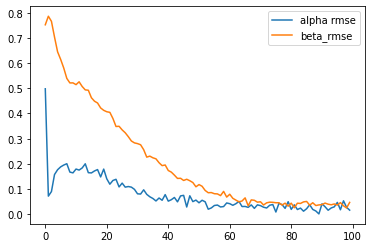

CPU times: user 24min, sys: 1.69 s, total: 24min 1s
Wall time: 1min 52s


In [9]:
%%time

from core.torch_mxl import TorchMXL

# instantiate MXL model
mxl = TorchMXL(dcm_dataset, batch_size=dcm_dataset.num_resp, use_inference_net=False, use_cuda=True)

# we are using Biogeme's results as a reference results for comparison
biogeme_alpha = np.array([-0.5080])
biogeme_beta = np.array([-0.1355, 0.4759, -1.5995, 0.5256, 0.1116, 0.5333])

# run Bayesian inference (variational inference)
results = mxl.infer(num_epochs=10000, true_alpha=biogeme_alpha, true_beta=biogeme_beta)

The "results" dictionary containts a summary of the results of variational inference, including means of the posterior approximations for the different parameters in the model:

In [10]:
results

{'Estimation time': 109.56723594665527,
 'Est. alpha': array([-0.5470354], dtype=float32),
 'Est. zeta': array([-0.14659663,  0.44419056, -1.6546605 ,  0.53451145,  0.11935437,
         0.60611176], dtype=float32),
 'Est. beta_n': array([[-0.177707  ,  1.0113539 , -0.7460837 ,  1.0617609 ,  0.27421653,
          0.60733056],
        [ 0.02112017,  0.7033575 , -1.8779882 ,  0.1324655 ,  0.2555254 ,
          0.88266927],
        [-0.46877855,  0.40089908, -1.4657907 ,  0.5733812 ,  0.4453968 ,
          0.4732788 ],
        [ 0.4595958 ,  0.24240786,  0.12841338,  1.1730931 , -0.71696794,
          0.57585335],
        [ 0.1390024 ,  0.15335542, -2.420903  , -0.7401863 , -0.30360064,
         -0.5032247 ],
        [-0.32350585,  0.45646194, -1.7088293 ,  1.2187247 ,  0.5599405 ,
          1.4971392 ],
        [-0.6117315 ,  0.46711022, -3.4774067 , -0.32910496,  0.6010447 ,
         -0.19895634],
        [ 0.92446315,  0.6807212 , -0.22696076,  1.7059586 , -0.2456472 ,
          1.24390